# Предсказание цен на автомобили реального рынка

- Денис Рыжов (denis.a.ryzhov@gmail.com)
- Дмитрий Коробов (Pls.mailbox@gmail.com)
- Дмитрий Копылов (kopiloff.dmitry@yandex.ru)

По условиям задачи: 
- нельзя пользоваться нейросетями
- данные должны быть либо взяты из общего доступа, либо скачаны, но не куплены.
- использовать стекинг

Важно:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Краткий отчёт

Работа состояла из 4 этапов:

1. Добыча данных (Data mining)
2. Анализ данных, подготовка и конструирование признаков (EDA and Feature engineering)
3. Исследование, выбор схемы и настройка моделей (Investigation, choice of prediction scheme and model adjustment)
4. Реализация предсказателя для конкретной задачи (предсказание цен ан BMW)

Данные для обучения моделей были скачаны с сайта *avto.ru*, распарсены и переведы в таблицу *csv*.

**Важно:** В качестве целевой переменной использовалась степень логарифма цены (степень равна 2/3). Такой подход позволил улучшить предсказания на несколько процентов MAPE.
Преобразование позволило сделать распределение целевого признака существенно равномернее. Степень логарифма подбиралась из соображений: свести медиану и среднего нового распределения к центру интервала изменения переменных (справа и слева от центра интервала — примерно равное число признаков). 

Определена функция метрики, рассчитывающая **MAPE в процентах**.е, выбор схемы и настройка моделей (Investigation, choice of prediction scheme and model adjustment)

Общей схемой построения предсказателя была выбрана двухступенчатая модель стекинга. В качестве как базовых, так и мета моделей рассматривались:
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `LightGBM`
- `CatBoostRegressor`
- `LinearRegression` (только как мета-модель — блендинг)

`RandomForestRegressor`, `LightGBM`, `CatBoostRegressor` оптимизировались по гиперпараметрам при помощи циклической покоординатной оптимизации:

Пока не достигался заданный максимальный уровень изменения метрики (`tolerance`=0.0001% для MAPE) осуществлялся циклический поиск минимума в пространстве гиперпараметров поиском минимума. Минимум искался на сетке по каждой координате внутри цикла. Каждый цикл осуществлял сужение диапазона поиска центрируясь на достигнутом на данном момент точки минимума. *Сейчас поиск сужен до двух последних циклов, поскольку в полной версии (на широком диапазоне) занимал существенное время.*



В качестве базовых моделей для стекинга рассматривались 4 упомянутые выше модели. Исследование их по параметрам, а также рассмотрение различных комбинаций в качестве «связки» базовых моделей показало, что в нашем случае будет использование нескольких моделей LightGBM с последующим мета-предсказанием ещё одной моделью LightGBM.


Исследование признаков при помощи метода `feature_importance` позволило избавиться на этапе построения базовых моделей от не значащих признаков.

Поскольку для предсказания данных выдан набор данных состоящий только из автомобилей BMW, то при реализации предсказателя из обучающего набора отобраны только BMW, ибо нет смысла для предсказания цен на BMW обучать модель на Ладах-Грантах и т.п. Данные обучающей и предоставленной внешней выборки приведены в сооотвестствии друг с другом, созданная модель обучена на обучающей выборке, содержащей только машины BMW, предсказана цена для внешних данных, "предоставленных заказчиком".

Как показали исследования, очень важны данные. Самим данным присуща довольна большая дисперсия, а их для финального предсказания всё же маловато - 6985. Важны и признаки - удаление самого млозначимого (по `feature importance` ~0.037%) признака приводит к ухудшение MAPE на 0.2%.

### Итог

Предсказание строится оптимизированной по гиперпараметрам моделью LightGBM.

### Мораль

Если бы не застряли так глубоко в общем случае, а просто аккуратно прочли ТЗ и сразу бы, а не в последний день поняли, что предсказывать надо только BMW, наверняка столь же тщательно проанализировав данные только для BMW, мы бы заметно улучшили показатели. Да и необходимых дополнительных признаков распарсили бы больше.

**Ergo:**

- **ТЗ надо читать внимательно**
- **читать надо всем**
- **а потом всем вместе и вслух**
- **и минимум дважды в неделю перечитывать**

        `Amen`

## Структура всего проекта

(Полную исследовательскую версию см. на [гитхабе](https://github.com/DenisRyzhov/SkillFactory-Study) - `rds3_rebuilt_comprehensive.ipynb`).


    1. Подготовка
        1.1 Загрузка модулей, определение констант и т.п.
        1.2 Загрузка данных
    2 Общая информация
        2.1 Дубликаты
        2.2 Пропуски
    3 Исследование признаков 
        3.1 Анализ численных переменных обучающей выборки
            3.1.0 Целевой признак ('price')
            3.1.1 Численные признаки
        3.2 Анализ категориальных признаков  обучающей выборки
            3.2.1 Упорядоченные категориальные признаки (Ordinal features)
            3.2.2 Категориальные 'one-hot' признаки
    4 Преобразование данных
        4.1 Преобразование типа данных
        4.2 Преобразование *One-Hot* переменных
        4.3 Преобразование *Ordinal* переменных
        4.4 Масштабирование численных переменных
    5 Prelaunch
        5.0 Target transformation
        5.1 Metrics function (MAPE)
        5.2 Features and target. Samples.
        5.3 Model optimizer
    6 Optimization of base models
        6.1 LightGBM with default parameters
        6.2 Optimization of base models (*LGBMRegressor*)
        6.3 Collection of nearly best base models for meta-phase
        6.4 About the best base model. Feature importance.
        6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)
    7 STACKING
        7.1 BLENDING
            7.1.1 Average prediction (Bagging)
            7.1.2 Weighted average prediction  (*LinearRegression*)
        7.2 Stacking  with LightGBM
            7.2.1 Optimization of  meta model
            7.2.2 Collect an ensemle of nearly best meta models
            7.2.3. About the best meta model. Feature importance.
        7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)    
    8 Приведение в соответствие признаков обучающей и внешней тестовой выборок
		8.1 Приведение в соответствие признаков обучающей и внешней тестовой выборок
		8.2 Извлечение данных из признака 'Комплектация'
		8.3 Приведение в соотвествие типов данных
		8.4 Создание "заточенного" под BMW обучающего набора
    9 Реализация предсказателя для конкретной задачи - предсказание цен на BMW (Estimator realization for BMW price prediction)
		9.1 Создание обучающей и прочих выборок
		9.2 Оптимизация конкретного предсказателя
		9.3 Создание набора базовых моделей для мета-стадии
		9.4 About the best 'BMW' base model. Feature importance.
		9.5 Мета-фаза. Bagging.
		9.6 Итоговое предсказание
    99 Results
    Appendix: Что ещё можно было бы сделать
        VERSIONS

<div class="alert alert-block alert-danger">   

    IN THIS SHORT VERSION OMITTED:
        (SEE COMREHENSIVE VERSION FOR DETAILS: )

    3 Исследование признаков
        3.1 Анализ численных переменных
            3.1.0 Целевой признак ('price')
            3.1.1 Численные признаки
        3.2 Категориальные признаки
            3.2.1 Упорядоченные категориальные признаки (Ordinal features)
            3.2.2 Категориальные 'one-hot' признаки
        4.2 Преобразование *One-Hot* переменных
        4.3 Преобразование *Ordinal* переменных
        4.4 Масштабирование численных переменных
        5.2 Features and target. Samples.
        6.1 LightGBM with default parameters
        6.2 Optimization of base models (*LGBMRegressor*)
        6.4 About the best base model. Feature importance.
        6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)
    7 STACKING
        7.1 BLENDING
            7.1.1 Average prediction (Bagging)
            7.1.2 Weighted average prediction  (*LinearRegression*)
        7.2 Stacking  with LightGBM
            7.2.1 Optimization of meta model
            7.2.2 Collect an ensemle of nearly best meta models
            7.2.3. About the best meta model. Feature importance.
        7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)
        9.5 Мета-фаза. Bagging.
    VERSIONS

In [1]:
### VERSIONS OF LIBRARIES

# !pip freeze

# python==3.7.7
# python : datetime, time, warnings

# catboost==0.23
# lightgbm==2.3.0
# matplotlib==3.2.2
# numpy==1.18.5
# pandas==1.0.5
# scipy==1.5.0
# seaborn==0.10.1
# sklearn==0.23.1

# 1. Подготовка

## 1.1 Загрузка модулей, определение констант и т.п.

In [2]:
### IMPORT

# import collections
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import warnings


# from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error, make_scorer

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgbm
# from catboost import CatBoostRegressor

# conda install -c conda-forge catboost
# conda install -c conda-forge lightgbm

In [3]:
### Global constants and settings

FILEPATH = "D:\\Data_Science_0\\Data_Science_=_Skill_Factory\\Real_DS_=_3_auto\\"
RANDOM_STATE = 1607

# warnings.filterwarnings("ignore")

# Plotting

sns.set(style='darkgrid', palette="bright")
sns.set(font_scale = 1.25)
FONT_SIZE = 14

Здесь задаются параметры общие для работы моделей во всё коде.

In [4]:
###  LAUNCH CONTROL CENTER (LCC)

## LGBM parameters (constant)
OBJECTIVE = 'mse'  ## mse, mae, mape
CATEGORICAL_FEATURE_LIST_LGBM = 'auto'
## The point is that lightGBM can handle only features, that are of `category` type, not `object`.


## Parameter for target transformation (power of log)

POWER = 1.5


### fraction of data transferred to models

FRAC = 1
FRAC_MODEL = 1

### Number od data transferred to models
### If exceeds the whole number, model will work with  all data

N_SAMPLE_BASE = 200000
N_SAMPLE_META = 200000


### The distance between vodels in hyperparameter space (for bagging/stacking)
STEP_INT = 1
STEP_LR = 0.001

### The number of points along one coordinate in hyperparameter space (for bagging/stacking)
### for base models
N_grid = 3
### for meta models
N_meta = 3

#### You also can adjust the range of hyperparameters for optimization search
### To do this go to '### MARK: RANGE ADJUST'

In [5]:
### Let's the game begin

total_time_start = time.time()

date_start = datetime.date.today()
time_start = datetime.datetime.now().time()

## 1.2 Загрузка данных

In [6]:
data = pd.read_csv(FILEPATH + "cars_aux.csv")
# data

# 2 Общая информация

In [7]:
data = data.drop(['Unnamed: 0'], axis=1)

## 2.1 Дубликаты

Есть 8846 дубликатов.

In [8]:
data.drop_duplicates(inplace=True, ignore_index=True)
print("Now we have {} entries.".format( len(data) ))

Now we have 124428 entries.


## 2.2 Пропуски

In [9]:
target_name = 'price'
missung_values = data.isna().sum().sort_values(ascending=False)
# missung_values

Пропуски есть только в признаке 'owners'.

Подавляющее число пропусков в 'owners' - это машины с нулевым пробегом, т.е., новые. Укажем таким машинам `owners=0`, остальные 13 пропусков удалим.

In [10]:
to_drop_mask = ( data['owners'].isna() ) & (data['mileage'] > 0)
print(to_drop_mask.sum())
# to_drop_mask[ to_drop_mask==True ]

17


In [11]:
data = data.drop(index=to_drop_mask[ to_drop_mask==True ].index).reset_index(drop=True)
data = data.fillna(0)
# data.isna().sum()

# 3 Исследование признаков

Определим какие признаки являются:
- численными (numerical)
- категориальными (categorical) среди которых есть
  - упорядоченные (ordinal)
  - бинарные (binary)
  - прочие неупорядоченные

In [12]:
features_set = set(data.columns) - set('price')

features_numerical = ['displacement', 'power', 'mileage', 'year']
features_numerical_set = set(features_numerical)

features_categorical_set = features_set - features_numerical_set
features_categorical = list(features_categorical_set)

features_ordinal = ['doors_count', 'owners']
features_ordinal_set = set(features_ordinal)

features_one_hot_set = features_categorical_set - features_ordinal_set
features_one_hot = list(features_one_hot_set)


print("There are {} variables.".format(len(features_set)))
print("There are {} numerical variables:".format( len(features_numerical) ), features_numerical)
print("There are {} categorical variables, amongst them:\n    {} ordinal variables:"
      .format( len(features_categorical_set), len(features_ordinal) ), features_ordinal)
print("        and")
print("    {} 'one-hot' variables:\n".
      format( len(features_one_hot) ), features_one_hot)

There are 62 variables.
There are 4 numerical variables: ['displacement', 'power', 'mileage', 'year']
There are 58 categorical variables, amongst them:
    2 ordinal variables: ['doors_count', 'owners']
        and
    56 'one-hot' variables:
 ['park-assist-r', 'condition', 'advanced-frontlighting-system', 'decorative-interior-lighting', 'night-vision', 'climate-control-1', 'transmission', 'airbag-6', 'park-assist-f', 'abs', 'airbag-curtain', 'cruise-control', 'halogen', 'sport-suspension', 'computer', 'airbag-passenger', 'collision-prevention-assist', 'lane-keeping-assist', 'vsm', 'airbag-driver', 'airbag-4', 'mark', 'airbag-rear-side', 'climate-control-3', 'airbag-side', 'rear-camera', 'gear_type', 'auto-park', 'section', 'multizone-climate-control', 'laser-lights', 'knee-airbag', 'front-camera', 'color', 'airbag-1', 'airbag-2', 'auto-cruise', 'navigation', 'engine_type', 'activ-suspension', 'esp', 'projection-display', 'led-lights', 'climate-control-2', 'parktronik', 'automatic-ligh

In [13]:
def num_variable_analysis(df, item, target_name, n_bins=100):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (boxplot)    
    df.boxplot(column=item, ax=axes[0])
    axes[0].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 2 (distplot)
    sns.distplot(df[item], bins=n_bins, kde=True, ax=axes[1], vertical=True)
    axes[1].set_title(item, fontsize=FONT_SIZE)
    plt.xticks(rotation=45)
    # axes.set_xlim((0, 100))
    
    
    # === FIG 3 (scatterplot)
    if item != target_name:
        axes[2] = sns.scatterplot(x=item, y=target_name, data=df)
    
    plt.show()
    
    # === Descriptive statistics
    describer = pd.DataFrame(df[item].describe()).T    
    print("==== {} ====".format(item))
    print(describer, "\n")
    
    
    # Pearson correlation coefficient for feature/target
    if item != target_name:
        corr_coeff = np.array(df[[item, target_name]].corr())[0, 1]
        print("Pearson correlation coefficient between '{}' and '{}' is {:.4f}."
              .format( item, target_name, corr_coeff ), "\n")
    
    
    # === Missing values
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), "\n"*2)

**Выделяются**:
1. 6 машин с ценой выше 40 млн руб.
2. несколько машин с объёмом двигателя свыше 7 л
3. автомобиль с мощностью двигателя 950 л.с.
4. минимальная мощность двигателя 11 л.с.
5. автомобили с нулевым объёмом двигателя
6. раритет 1990 года ценой за 2 млн руб

1. 6 машин с ценой выше 40 млн руб.- несколько машин с объёмом двигателя свыше 7 л
 - люксовые (Maybach S-Класс и Mercedes-Benz S-Класс (W220)) и спортивные машины (Mercedes-Benz SLR McLaren, Aston Martin Vantage). С Aston Martin Vantage есть загадка: модель выпускалась с 2005, а в базе стоит 1999 год...
2. 13 машин с объёмом двигателя свыше 7 л
 - 3 "пассажирских грузовика" (SUV) Chevrolet Suburban 9-го поколения и его производная Chevrolet Avalanche
 - 2 "членовоза" ЗИЛ-41047
 - "спортсмены" Dodge Viper и Chevrolet Corvette (по 3 штуки)
 - фургон Ford Econoline
3. автомобиль с мощностью двигателя 950 л.с.
 - Шоу-кар «Формула-1»
4. аавтомобили с мощностью двигателя меньше 30 л.с.:
 - СМЗ С-3Д - инвалидка" (2)
 - Bajaj Qute - индийский квадрицикл (3)
 - Renault Twizy - еропейский электро-квадрицикл (2)
 - LADA (ВАЗ) - 1111 Ока (5) 
5. автомобили с нулевым объёмом двигателя
 - электромобили
6. раритет 1990 года ценой за 2 млн
 - Это внедорожник Lamborghini LM002 ! 
 
Далеко не рядовые 120 машин. Все они имеют право на существование, но для общего рынка некоторые будут скорее аномалиями и способны подпортить предсказатель.

Сейчас удаляем все, кроме "Оки" и электромобилей.

In [14]:
if target_name == 'price_log10':
    data = data[ data[target_name] < np.log10(40*10**6)]
else:
    data = data[ data[target_name] < 40*10**6]

data = data[ data['displacement'] <= 7000 ]
data = data[ data['power'] < 900 ]
data = data[ data['power'] > 20 ]
# data = data[ data['engine_type'] != 'ELECTRO' ]

if target_name == 'price_log10':
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > np.log10(20*10**6))].index
else:
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > 20*10**6)].index
    
data = data.drop(index=index_to_drop).reset_index(drop=True)
# data

Из аномалий - 0-дверная машина (2 штуки) и пятидверки с ценой свыше 35 млн руб.

Машинами без дверей оказались гоночные болиды Dallara F399/300 и Ariel Atom. Удаляем как редкую редкость.

Машинами с ценой за 35 млн руб. оказался люксовый внедорожник Rolls-Royce Cullinan и Geländewagen. Тоже удаляем как редких птиц для российского (даже московского) авторынка.

In [15]:
data = data[ data['doors_count']>0 ]

limit_t = 35*10**6

if target_name == 'price_log10':
    limit_t = np.log10(limit_t)

data = data[ data[target_name]<limit_t ].reset_index(drop=True)

Преобразуем 16-ричную кодировку цвета в названия.

In [16]:
## https://hysy.org/color/97948F
## https://www.colorhexa.com/0000cc

color_dict = {}

color_dict['040001'] = 'black'  ## в ПТС как чёрный (#601)
color_dict['FAFBFB'] = 'white'
color_dict['CACECB'] = 'silver'
color_dict['97948F'] = 'grey'
color_dict['0000CC'] = 'strong-blue'

color_dict['200204'] = 'mostly-black-red'  ## в ПТС как коричневый металлик (#798)
color_dict['EE1D19'] = 'vivid-red'
color_dict['007F00'] = 'dark-green'
color_dict['C49648'] = 'french-beige'
color_dict['22A0F8'] = 'vivid-blue'  ## лазурный

color_dict['FFD600'] = 'yellow'
color_dict['660099'] = 'purple'
color_dict['4A2197'] = 'dark-violet'
color_dict['DEA522'] = 'golden'
color_dict['FF8649'] = 'orange'
color_dict['FFC0CB'] = 'pink'

data['color'] = data['color'].map(color_dict)
# data

Странности:
1. `body_type` - три типа кузова с очень малым числом машин:
 - TARGA            - 8 
 - LIMOUSINE        - 3 
 - SPEEDSTER        - 1 

2. `engine_type` - Всего 19 машин с двигателем на газу. Они погоду не сделают - удалим.
 - LPG            - 19

Основываясь на статье в вики "[Car body style]" (https://en.wikipedia.org/wiki/Car_body_style) укрупним категории кузова в соответсвии с таблицей (невошедшие - без изменений):

| было | стало |
| :-- | :-- |
| WAGON          | VAN |
| MINIVAN        | VAN |
| COMPACTVAN     | VAN |
| MICROVAN       | VAN |
| TARGA          | CABRIO |
| LIMOUSINE      | SEDAN |
| SPEEDSTER      | COUPE  |

In [17]:
dict_body = {}

dict_body['ALLROAD'] = 'ALLROAD'
dict_body['SEDAN'] = 'SEDAN'
dict_body['HATCHBACK'] = 'HATCHBACK'

dict_body['WAGON'] = 'VAN'
dict_body['MINIVAN'] = 'VAN'
dict_body['COMPACTVAN'] = 'VAN'

dict_body['COUPE'] = 'COUPE'
dict_body['PICKUP'] = 'PICKUP'
dict_body['VAN'] = 'VAN'
dict_body['ROADSTER'] = 'ROADSTER'
dict_body['CABRIO'] = 'CABRIO'

dict_body['MICROVAN'] = 'VAN'
dict_body['TARGA'] = 'CABRIO'
dict_body['LIMOUSINE'] = 'SEDAN'
dict_body['SPEEDSTER'] = 'COUPE'

data['body_type'] = data['body_type'].map(dict_body)
data['body_type'].value_counts()

SEDAN        44667
ALLROAD      43019
HATCHBACK    17081
VAN          11490
COUPE         1960
PICKUP         834
ROADSTER       209
CABRIO         209
Name: body_type, dtype: int64

In [18]:
data = data[ data['engine_type'] != 'LPG' ]
data['engine_type'].value_counts()

GASOLINE    107178
DIESEL       16718
HYBRID         375
ELECTRO         89
Name: engine_type, dtype: int64

# 4 Преобразование данных

## 4.1 Преобразование типа данных

In [19]:
data['owners'] = data['owners'].astype('int')
features_as_category = list( features_categorical_set - set(['doors_count', 'owners', 'price']) )

# features_as_category

In [20]:
for item in features_as_category:
    data[item] = data[item].astype('category')
    
# data.info(memory_usage='deep')

# 5 Prelaunch

## 5.0 Target transformation

$$z = \log_{10}y$$

$${\rm transform:}\qquad s = z^{1/p} = (\log_{10}y)^{1/p}$$

$${\rm inverse \,\, transform:}\qquad y = 10^{y^p}$$

In [21]:
def sqrtn(x, power):
    ans = []
    for z in x:
        if z >= 0:
            ans.append( z**(1/power) )
        else:
            ans.append( -np.abs(z)**(1/power) )
    return np.array(ans)
    


def target_transform(y, p):
    z = np.log10(y)
    s = sqrtn(z, p)
    return s



def target_transform_inv(s, p):
    z = s**p
    y = 10**z
    return y

## 5.1 Metrics function (MAPE)

In [22]:
import numpy as np
def mean_absolute_percent_error(y_true, y_pred):
    
    """
    The mean absolute percentage error (MAPE).
    Note 1: Here MAPE is measured in %%.
    Note 2: The zero values of y_true are ignored.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs( (y_true - y_pred) / y_true) ) * 100

# mape_scorer = make_scorer(mean_absolute_percent_error, greater_is_better=False)

The maximal relative error of target transformation = 5.16047601757076e-15


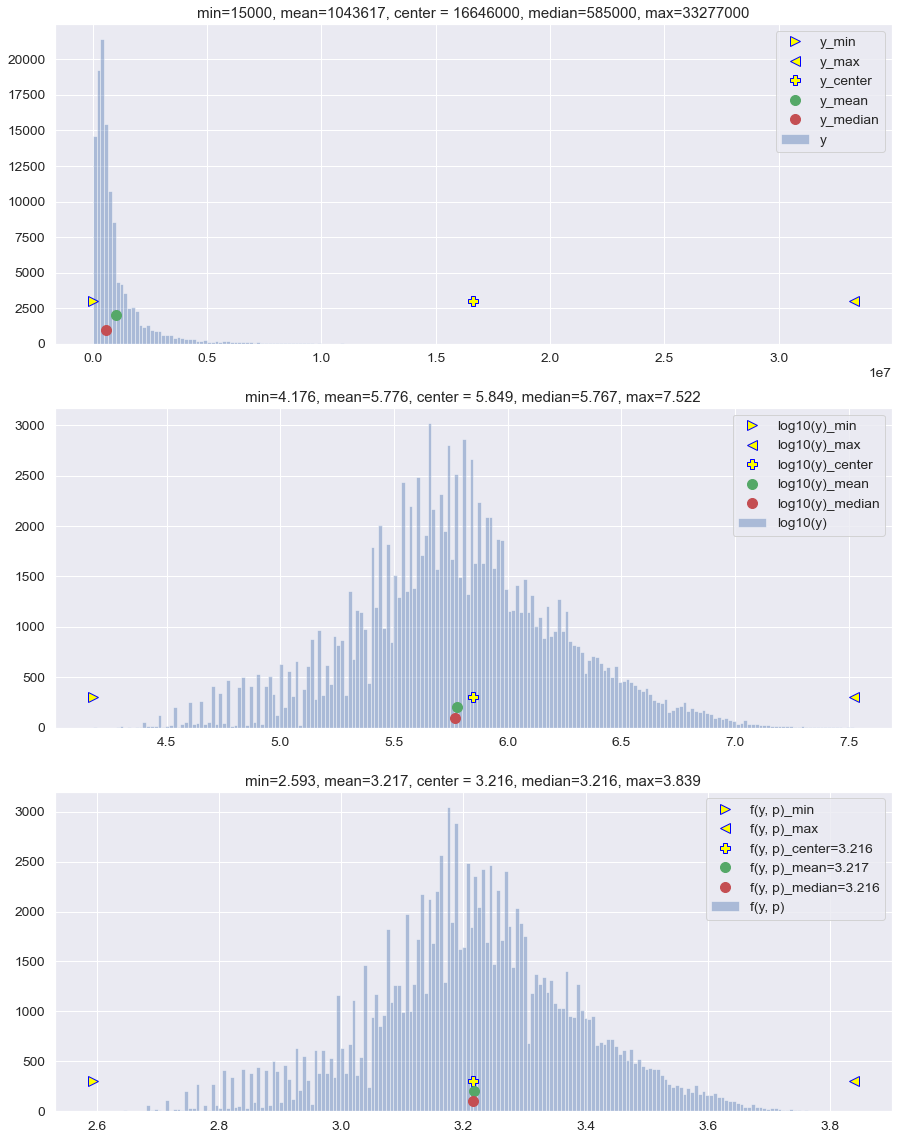

Wall time: 2.73 s


In [23]:
%%time

y = data[target_name]

p = 1.5
z = target_transform(y, p)
s = target_transform_inv(z, p)


n_bins = 200

plt.subplots(3, 1, figsize=(15, 20))

plt.subplot(3, 1, 1)
level = 1000
sns.distplot(y, bins=n_bins, kde=False, label='y')
plt.plot(y.min(), 3*level, '>', color='yellow', markeredgecolor='blue', markersize=10, label='y_min')
plt.plot(y.max(), 3*level, '<', color='yellow', markeredgecolor='blue', markersize=10, label='y_max')
plt.plot((y.max()+y.min())/2, 3*level, 'P', color='yellow', markeredgecolor='blue', markersize=10, label='y_center')
plt.plot(y.mean(), 2*level, 'go', markersize=10, label='y_mean')
plt.plot(np.median(y), level, 'ro', markersize=10, label='y_median')
plt.title("min={}, mean={:.0f}, center = {:.0f}, median={:.0f}, max={}"
          .format(y.min(), y.mean(), (y.max()+y.min())/2, np.median(y), y.max()))
plt.legend()
plt.xlabel('')

y_log = np.log10(y)

plt.subplot(3, 1, 2)
level = 100
sns.distplot(y_log, bins=n_bins, kde=False, label='log10(y)')
plt.plot(y_log.min(), 3*level, '>', color='yellow', markeredgecolor='blue', markersize=10, label='log10(y)_min')
plt.plot(y_log.max(), 3*level, '<', color='yellow', markeredgecolor='blue', markersize=10, label='log10(y)_max')
plt.plot((y_log.max()+y_log.min())/2, 3*level, 'P',
         color='yellow', markeredgecolor='blue', markersize=10, label='log10(y)_center')
plt.plot(y_log.mean(), 2*level, 'go', markersize=10, label='log10(y)_mean')
plt.plot(np.median(y_log), level, 'ro', markersize=10, label='log10(y)_median')
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(y_log.min(), y_log.mean(), (y_log.max()+y_log.min())/2, np.median(y_log), y_log.max()))
plt.legend()
plt.xlabel('')

plt.subplot(3, 1, 3)
level = 100
sns.distplot(z, bins=n_bins, kde=False, label='f(y, p)')
plt.plot(z.min(), 3*level, '>', color='yellow', markeredgecolor='blue', markersize=10, label='f(y, p)_min')
plt.plot(z.max(), 3*level, '<', color='yellow', markeredgecolor='blue', markersize=10, label='f(y, p)_max')
plt.plot((z.max()+z.min())/2, 3*level, 'P', color='yellow', markeredgecolor='blue', markersize=10, 
         label='f(y, p)_center={:.3f}'.format( (z.max()+z.min())/2 ))
plt.plot(z.mean(), 2*level, 'go', markersize=10, label='f(y, p)_mean={:.3f}'.format( z.mean() ))
plt.plot(np.median(z), level, 'ro', markersize=10, label='f(y, p)_median={:.3f}'.format( np.median(z) ))
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(z.min(), z.mean(), (z.max()+z.min())/2, np.median(z), z.max()))
plt.legend()
plt.xlabel('')

print("The maximal relative error of target transformation =",
      ( np.abs( target_transform_inv(target_transform(y, p), p) - y )/y ).max())

plt.show()

In [24]:
# y_for_d = np.sort(y)
# distances = np.diff(y_for_d)
# distances


# fig, ax = plt.subplots(3, 1, figsize=(16, 24))

# plt.subplot(3, 1, 1)
# plt.plot(y_for_d[1:], distances, '-b')
# plt.title("Distance between neighbouring points")

# plt.subplot(3, 1, 2)
# plt.semilogy(y_for_d[1:], distances)

# plt.subplot(3, 1, 3)
# plt.loglog(y_for_d[1:], distances)
# plt.show()

## 5.3 Model optimizer

In [25]:
def model_one_coord_search(EstimatorClass, params_fixed, params_limits, 
                           data_trr, data_vall, target_name, n_sample, 
                           num_points=21, metrics_func=None,
                           lgb_categorical_feature_list='auto',
                           verbose=False, visualize=False):
    """
    This FUNCTION 
    - creates the model;
    - trains it with the train data;
    - makes the prediction from valid data;
    - calculate metrics and
    - measures the time of performance of all above actions.
    
    NOTE:
    ...
    ...LighnGBM (marked as 'lgb')
    
    INPUT:
    
    
    OUTPUT:
    
    Version 1.1
    Needs libraries:
    - pandas
    - numpy
    - scikit-learn
    - time
    
    """
    
    
    
    param_current = params_fixed.copy()

    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=param_current['random_state'])
        
    ### target transformation
    ###
    data_tr[target_name] = target_transform(data_tr[target_name], POWER)
        
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
    
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    
    for key in params_limits.keys():
        if params_limits[key][2] == 'int':
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points, dtype=int)
        else:
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points)
                        
        param_range = np.unique(param_range)
        
        metrics_list = []
        performance_list = []
        metrics_best = 10**10
        best_param = None
        
        for k, point in enumerate(param_range):
            param_current[key] = point
            
            ### ** - The best way to initialise estimator with the parameters
            ### would be to unpack dictionary
            if EstimatorClass != 'lgbm':
                t0 = time.time()
                model = EstimatorClass(**param_current)
                model.fit(feat_train, targ_train)
            else:
                # We should give LightGBM data converted to his own form 
                # Here data is pandas.DataFrame with catecorical data, label is target
                train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                          categorical_feature=lgb_categorical_feature_list)
                t0 = time.time()
                model = lgbm.train(param_current, train_data)
                
            ### target inverse transformation
            ###
            prediction_transformed = model.predict(feat_valid)
            prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
        
            
            metrics = metrics_func(targ_valid, prediction)
            metrics_list.append(metrics)
            
            if metrics < metrics_best:
                metrics_best = metrics
                best_param = point
            
            performance_time = time.time() - t0
            performance_list.append(performance_time)
            
            if verbose:
                print("{} : {} = {:.6f} : METRICS = {:.4f} ; eval_time = {:.3f} sec"
                      .format( k, key, point, metrics, performance_time ))
        
        metrics_array = np.array(metrics_list)
        performance_array = np.array(performance_list)
        
        if visualize:
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            
            plt.plot(best_param, metrics_best, 'o', markersize=14, 
                     markerfacecolor='w', markeredgecolor='r', label="best point")
            plt.plot(param_range, metrics_array, '-bo', label="")
            plt.legend()
            plt.title("The best metrics is {:.4f} for {}={}"
                      .format( metrics_best, key, best_param ))
        
    return metrics_array, param_range, performance_array, best_param, metrics_best

Test of `model_one_coord_search` (Stage 1)

In [26]:
def model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                            data_tr, data_val, target_name, n_sample, 
                            num_points=21, metrics_func=None,
                            lgb_categorical_feature_list='auto',
                            verbose=False, visualize=False):
    
    
    param_current = params_fixed.copy()
    
    best_param_loop = {}
    metrics_best_loop = 10**10
    
    param_lim_1 = {}
    result_dict = {}
    for key in params_limits.keys():
        param_lim_1[key] = params_limits[key]
        if verbose:
            print()
            print("^^^")
            print("Fixed", param_current)
            print("Varies", param_lim_1)
            print("^^^\n")
        result = model_one_coord_search(EstimatorClass, param_current, param_lim_1, 
                                        data_tr, data_val, target_name, n_sample, 
                                        num_points=num_points, metrics_func=metrics_func,
                                        lgb_categorical_feature_list=lgb_categorical_feature_list,
                                        verbose=verbose, visualize=visualize)
        metrics_array, param_range, performance_array, best_param, metrics_best = result
        
        if best_param < metrics_best_loop:
            metrics_best_loop = best_param
        
        param_current[key] = best_param
        result_dict[key] = best_param
        param_lim_1 = {}
        
        if verbose:
            print()
            print("*** Best {} = {} witn METRICS = {}".format(key, best_param, metrics_best))
        
    return result_dict, metrics_best

In [27]:
def model_coord_search(EstimatorClass, params_fixed, params_limits, 
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False):
    
    """
    This fuction performs the search of the best parameters over specified parameter values 
    for an estimator using coordinate search.
    
    PARAMETERS:
        
    EstimatorClass - estimator object. 
        This is assumed to implement the scikit-learn estimator interface with `fit` and `predict` methods. 
        LightGBM is a special case - you should define EstimatorClass as a string 'lgbm' and
        `import lightgbm as lgbm` .
    
    params_fixed - dict. 
        Dictionary with parameters names (str) as keys and lists of parameter settings to try. 
        Such a list contains three elements: 
            First - the minimal limit for the parameter grid ('int' or 'float')
            Second - the maximal limit for the parameter grid ('int' or 'float')
            Third - the type of variable (str: 'int' or 'float'). The string which is not 'int' treated as 'float'.    
    
    params_limits - dict.
    
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False
    """
    
    metrics_in = 10**10
    metrics_out = 10**9
    
    metrics_best = 10**10
    best_params = {}
    
    k = 0
    metrics_to_plot = []
    while metrics_in - metrics_out >= tol: 
        t0 = time.time()
        if verbose_cycle:
            print("[{}]".format(k))
            print("params_limits :", params_limits)
            
        metrics_in = metrics_out        
        result_dict, metrics_out = model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                                                            data_tr, data_val, target_name, n_sample, 
                                                            num_points=num_points, metrics_func=metrics_func,
                                                            lgb_categorical_feature_list='auto',
                                                            verbose=verbose_detail, visualize=visualize_detail)
        if metrics_out < metrics_best:
            metrics_best = metrics_out
            best_params = result_dict
        
        
        metrics_to_plot.append(metrics_out)
        
        for key in params_limits.keys():
            step_key = ( params_limits[key][1] - params_limits[key][0] ) / ( num_points - 1 )
            if params_limits[key][2] == 'int':
                step_key = int(np.ceil(step_key))
                
            lim_min = result_dict[key] - step_key
            if lim_min < params_limits[key][0]:
                lim_min = params_limits[key][0]
            lim_max = result_dict[key] + step_key
            params_limits[key] = [ lim_min, lim_max, params_limits[key][2] ]
            
        
        if verbose_cycle:
            print("OUT [{}]: M(i) = {:.6f}; M(i+1) = {:.6f} (tol={})"
                  .format(k, metrics_in, metrics_out, tol))
            print("result_dict", result_dict)
            print("Iteration time = {:.2f} sec".format( time.time() - t0 ))
            print("\n", "~ "*9, "\n")
        k += 1
        if k > iter_lim:
            print("The limit of iterations is achieved. Sorry!")
            break
            
    print(min(metrics_to_plot))
    if visualize_cycle:        
        shift = 0.03*(max(metrics_to_plot) - min(metrics_to_plot))
        x = np.arange(0, len(metrics_to_plot))
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        plt.plot(x, metrics_to_plot, '-bo')
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Metrics", fontsize=14)
        for a, b in zip(x, metrics_to_plot): 
            plt.text(a, b+shift, str( np.round(b, 4)), fontsize=12)
        plt.show()
    
    print()
    print("Done. Congratulations!")
    
    return best_params, metrics_best

# 6 Optimization of base models

## 6.3 Collection of nearly best base models for meta-phase

In [28]:
def model_collector(EstimatorClass, params_fixed, params_opt, 
                    data_trr, data_vall, target_name, n_sample,
                    metrics_func=None,
                    lgb_categorical_feature_list='auto'):
    
    """
    """
    
    
    import itertools
    
    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    try:
        rs = params_fixed['random_state']
    except:
        rs = None
    
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=rs)
    

    
    ### target transformation
    ###
    data_tr[target_name] = target_transform(data_tr[target_name], POWER)
    
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
        
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    result_df = pd.DataFrame( columns=list(params_opt.keys())+["metrics", "performance_time", "model"] )
    print(list(result_df.columns))
    
    keys, values = zip(*params_opt.items())
    ## list of dicts
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for k, dict_point in enumerate(permutations_dicts):
        param_current = {**params_fixed, **dict_point}
        
        if EstimatorClass != 'lgbm':
            t0 = time.time()
            model = EstimatorClass(**param_current)
            model.fit(feat_train, targ_train)
        else:
            # We should give LightGBM data converted to his own form 
            # Here data is pandas.DataFrame with catecorical data, label is target
            train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                      categorical_feature=lgb_categorical_feature_list)
            t0 = time.time()
            model = lgbm.train(param_current, train_data)
                
        prediction_transformed = model.predict(feat_valid)
        prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
        
        metrics = metrics_func(targ_valid, prediction)
        
        performance_time = time.time() - t0
        
        list_to_append = list( dict_point.values() ) + [metrics, performance_time, model]
        print(list_to_append)
        result_df = result_df.append(pd.DataFrame([list_to_append], columns=result_df.columns), ignore_index=True)
        
    result_df = result_df.sort_values('metrics', ascending=True).reset_index(drop=True)
        
    return result_df

# 8 Приведение в соответствие данных обучающей и внешней тестовой выборок

Приведение в сооветствиие данных обучающей и внешней тестовой выборок предполагает соответсвие признаков по сути, названию и содержанию.

Загрузим внешние данные ("представленные заказчиком для прогнозирования").

In [29]:
test = pd.read_csv(FILEPATH + "test.csv")
# test

Внешние данные содержат 3837 записей. По сути данные совпадают с данными, которые мы будем использовать для построения общей модели. 

Требуется приведение в соответствие:
- названий признаков
- формата представления данных

In [30]:
test = test.drop(['vehicleConfiguration', 'description', 'Состояние', 'ПТС', 
                  'Таможня', 'Владение', 'id', 'modelDate'], axis=1)
# test.columns

## 8.1 Приведение в соответствие признаков обучающей и внешней тестовой выборок

### bodyType

In [31]:
dict_body_type = {}

dict_body_type['седан'] = 'SEDAN'
dict_body_type['внедорожник 5 дв.'] = 'ALLROAD'
dict_body_type['хэтчбек 3 дв.'] = 'HATCHBACK'
dict_body_type['хэтчбек 5 дв.'] = 'HATCHBACK'
dict_body_type['купе'] = 'COUPE'

dict_body_type['родстер'] = 'ROADSTER'
dict_body_type['седан 2 дв.'] = 'SEDAN'
dict_body_type['лифтбек'] = 'LIFTBACK'
dict_body_type['универсал 5 дв.'] = 'HATCHBACK'
dict_body_type['кабриолет'] = 'CABRIO'
dict_body_type['компактвэн'] = 'VAN'

dict_body_type

{'седан': 'SEDAN',
 'внедорожник 5 дв.': 'ALLROAD',
 'хэтчбек 3 дв.': 'HATCHBACK',
 'хэтчбек 5 дв.': 'HATCHBACK',
 'купе': 'COUPE',
 'родстер': 'ROADSTER',
 'седан 2 дв.': 'SEDAN',
 'лифтбек': 'LIFTBACK',
 'универсал 5 дв.': 'HATCHBACK',
 'кабриолет': 'CABRIO',
 'компактвэн': 'VAN'}

In [32]:
test['body_type'] = test['bodyType'].map(dict_body_type)
test = test.drop(['bodyType'], axis=1)
# test

У BMW нет пикапов - удалим их из обучающей выборки.

### brand

In [33]:
# test['brand'].value_counts()

В предоставленном для предсказания датасете машины только марки BMW.
То есть, это не вариативный признак - удаляем его из представленного набора, а обучающий сужаем до машин только марки BMW. 

*Все операции с обучающем набором выполним в конце раздела - перед обучением "заточенной под BMW" модели*.

In [34]:
test = test.drop(['brand'], axis=1)
# test

### color

In [35]:
dict_color = {}

dict_color['чёрный'] = 'black'
dict_color['белый'] = 'white'
dict_color['синий'] = 'strong-blue'
dict_color['серый'] = 'grey'
dict_color['коричневый'] = 'mostly-black-red'
dict_color['серебристый'] = 'silver'
dict_color['красный'] = 'vivid-red'
dict_color['бежевый'] = 'french-beige'
dict_color['голубой'] = 'vivid-blue'
dict_color['зелёный'] = 'dark-green'
dict_color['оранжевый'] = 'orange'
dict_color['золотистый'] = 'golden'
dict_color['пурпурный'] = 'purple'
dict_color['фиолетовый'] = 'dark-violet'
dict_color['жёлтый'] = 'yellow'

dict_color

{'чёрный': 'black',
 'белый': 'white',
 'синий': 'strong-blue',
 'серый': 'grey',
 'коричневый': 'mostly-black-red',
 'серебристый': 'silver',
 'красный': 'vivid-red',
 'бежевый': 'french-beige',
 'голубой': 'vivid-blue',
 'зелёный': 'dark-green',
 'оранжевый': 'orange',
 'золотистый': 'golden',
 'пурпурный': 'purple',
 'фиолетовый': 'dark-violet',
 'жёлтый': 'yellow'}

In [36]:
test['color'] = test['color'].map(dict_color)
# test

### fuelType

In [37]:
dict_engine_type = {}

dict_engine_type['бензин'] = 'GASOLINE'
dict_engine_type['дизель'] = 'DIESEL'
dict_engine_type['гибрид'] = 'HYBRID'
dict_engine_type['электро'] = 'ELECTRO'

dict_engine_type

{'бензин': 'GASOLINE',
 'дизель': 'DIESEL',
 'гибрид': 'HYBRID',
 'электро': 'ELECTRO'}

In [38]:
test['engine_type'] = test['fuelType'].map(dict_engine_type)
test = test.drop(['fuelType'], axis=1)
# test

### name

In [39]:
def model_extract(x):
    result = re.findall(r'^\w+', x)
    
    return result[0]

# \w     Любая цифра или буква (\W — все, кроме буквы или цифры)
# ^ и $  Начало и конец строки соответственно
# +      1 и более вхождений шаблона слева

In [40]:
test['model'] = test['name'].apply(model_extract)
test = test.drop(['name'], axis=1)
# test

In [41]:
dict_model = {}

dict_model['840d'] = '8 серия'

dict_model['725Ld'] = '7 серия'
dict_model['728i'] = '7 серия'
dict_model['750Li'] = '7 серия'
dict_model['730d'] = '7 серия'
dict_model['730i'] = '7 серия'
dict_model['730Ld'] = '7 серия'
dict_model['730Li'] = '7 серия'
dict_model['735i'] = '7 серия'
dict_model['735Li'] = '7 серия'
dict_model['740d'] = '7 серия'
dict_model['740i'] = '7 серия'
dict_model['740Ld'] = '7 серия'
dict_model['740Li'] = '7 серия'
dict_model['745i'] = '7 серия'
dict_model['745Li'] = '7 серия'
dict_model['750d'] = '7 серия'
dict_model['750i'] = '7 серия'
dict_model['750Ld'] = '7 серия'
dict_model['760i'] = '7 серия'
dict_model['760Li'] = '7 серия'
dict_model['M760Li'] = '7 серия'
dict_model['ActiveHybrid'] = '7 серия'


dict_model['620d'] = '6 серия'
dict_model['630d'] = '6 серия'
dict_model['630i'] = '6 серия'
dict_model['640d'] = '6 серия'
dict_model['640i'] = '6 серия'
dict_model['645i'] = '6 серия'
dict_model['650i'] = '6 серия'

dict_model['5'] = '5 серия'
dict_model['518'] = '5 серия'
dict_model['520d'] = '5 серия'
dict_model['520i'] = '5 серия'
dict_model['520Li'] = '5 серия'
dict_model['523i'] = '5 серия'
dict_model['525d'] = '5 серия'
dict_model['525i'] = '5 серия'
dict_model['525xd'] = '5 серия'
dict_model['525xi'] = '5 серия'
dict_model['528i'] = '5 серия'
dict_model['528Li'] = '5 серия'
dict_model['530d'] = '5 серия'
dict_model['530i'] = '5 серия'
dict_model['530Li'] = '5 серия'
dict_model['530xd'] = '5 серия'
dict_model['530xi'] = '5 серия'
dict_model['535d'] = '5 серия'
dict_model['535i'] = '5 серия'
dict_model['540i'] = '5 серия'
dict_model['545i'] = '5 серия'
dict_model['550i'] = '5 серия'

dict_model['4'] = '4 серия'
dict_model['420d'] = '4 серия'
dict_model['420i'] = '4 серия'
dict_model['428i'] = '4 серия'
dict_model['430i'] = '4 серия'
dict_model['440i'] = '4 серия'

dict_model['3'] = '3 серия'
dict_model['316'] = '3 серия'
dict_model['316i'] = '3 серия'
dict_model['318d'] = '3 серия'
dict_model['318i'] = '3 серия'
dict_model['320d'] = '3 серия'
dict_model['320i'] = '3 серия'
dict_model['323i'] = '3 серия'
dict_model['325i'] = '3 серия'
dict_model['325xi'] = '3 серия'
dict_model['328i'] = '3 серия'
dict_model['330d'] = '3 серия'
dict_model['330i'] = '3 серия'
dict_model['330xd'] = '3 серия'
dict_model['330xi'] = '3 серия'
dict_model['335i'] = '3 серия'
dict_model['335xi'] = '3 серия'
dict_model['340i'] = '3 серия'

dict_model['2'] = '2 серия'
dict_model['220i'] = '2 серия'
dict_model['218i'] = '2 серия Active Tourer'
dict_model['Active'] = '2 серия Active Tourer'
dict_model['M235i'] = '2 серия Grand Tourer'

dict_model['1'] = '1 серия'
dict_model['116i'] = '1 серия'
dict_model['118i'] = '1 серия'
dict_model['118d'] = '1 серия'
dict_model['120d'] = '1 серия'
dict_model['120i'] = '1 серия'
dict_model['125i'] = '1 серия'
dict_model['130i'] = '1 серия'
dict_model['135i'] = '1 серия'
dict_model['M135i'] = '1 серия'

dict_model['25d'] = 'X5'
dict_model['30d'] = 'X5'
dict_model['35d'] = 'X5'
dict_model['35i'] = 'X5'
dict_model['40i'] = 'X5'
dict_model['40d'] = 'X5'
dict_model['48i'] = 'X5'

dict_model['M50d'] = 'X5 M'
dict_model['M50i'] = 'X5 M'

dict_model['20d'] = 'X3'
dict_model['25i'] = 'X3'
dict_model['28i'] = 'X3'
dict_model['50i'] = 'X3'
dict_model['30i'] = 'X3'
dict_model['xDrive20d'] = 'X3'

dict_model['M40d'] = 'X3 M'
dict_model['M40i'] = 'X3 M'

dict_model['18d'] = 'X1'
dict_model['18i'] = 'X1'
dict_model['20i'] = 'X1'
dict_model['23d'] = 'X1'
dict_model['sDrive18i'] = 'X1'
dict_model['xDrive18d'] = 'X1'
dict_model['xDrive20i'] = 'X1'

dict_model['35is'] = 'Z4'
dict_model['23i'] = 'Z4'

dict_model['M850i'] = 'M8'
dict_model['M550d'] = 'M5'
dict_model['M550i'] = 'M5'
dict_model['Competition'] = 'M5'
dict_model['CS'] = 'M4'
dict_model['M340i'] = 'M3'

dict_model['Electro'] = 'i3'

# dict_model

In [42]:
test['model'] = test['model'].map(dict_model)
# test

В обучающей выборке есть модели, отсутствующие в выборке, предоставленной для предсказания. Удалим их из обучающей выборки.

### numberOfDoors

In [43]:
test['doors_count'] = test['numberOfDoors'].astype('int')
test = test.drop(['numberOfDoors'], axis=1)
# test

### productionDate

In [44]:
test['year'] = test['productionDate'].astype('int')
test = test.drop(['productionDate'], axis=1)
# test

### vehicleTransmission

In [45]:
dict_transmission = {}

dict_transmission['автоматическая'] = 'AUTOMATIC'
dict_transmission['механическая'] = 'MECHANICAL'
dict_transmission['роботизированная'] = 'ROBOT'

In [46]:
test['transmission'] = test['vehicleTransmission'].map(dict_transmission)
test = test.drop(['vehicleTransmission'], axis=1)
# test

### engineDisplacement

In [47]:
def displacement_extract(x):
    try:
        return int(float(x[:-4])*1000)
    except:
        ### it's an electro
        return 0

In [48]:
test['displacement'] = test['engineDisplacement'].apply(displacement_extract)#.astype('int')
test = test.drop(['engineDisplacement'], axis=1)
# test['displacement'].value_counts()
# test

### enginePower

In [49]:
def power_extract(x):
    try:
        return int(x[:-4])
    except:
        return x

In [50]:
test['power'] = test['enginePower'].apply(power_extract)
test = test.drop(['enginePower'], axis=1)
# test

### mileage

In [51]:
test['mileage'] = test['mileage'].astype('int')
# test

### Привод

In [52]:
dict_gear_type = {}

dict_gear_type['полный'] = 'ALL_WHEEL_DRIVE'
dict_gear_type['задний'] = 'REAR_DRIVE'
dict_gear_type['передний'] = 'FORWARD_CONTROL'

dict_gear_type

{'полный': 'ALL_WHEEL_DRIVE',
 'задний': 'REAR_DRIVE',
 'передний': 'FORWARD_CONTROL'}

In [53]:
test['gear_type'] = test['Привод'].map(dict_gear_type)
test = test.drop(['Привод'], axis=1)
# test

### Руль

In [54]:
test = test.drop(['Руль'], axis=1)
# test

В предоставленном для предсказания набора только  леворульные машины, а в обучающем есть 2 праворульные BMW. Удалим признак и из предоставленного набора (только одно значение - неиформативен), и из "заточенного под BMW" обучающего набора (нет нужды обучать предсказатель под машины, для которых не надо предсказывать).

### Владельцы

In [55]:
dict_owners = {}

dict_owners['1 владелец'] = 1
dict_owners['2 владельца'] = 2
dict_owners['3 или более'] = 3

In [56]:
test['owners'] = test['Владельцы'].map(dict_owners)
test = test.drop(['Владельцы'], axis=1)
# test

Иного выхода как заполнить пропуски в числе владельцев нулями не видно.

In [57]:
test = test.fillna(0)
test['owners'] =  test['owners'].astype('int')
# test

## 8.2 Извлечение данных из признака 'Комплектация'

In [58]:
def complect_splitter(x):
    bag = []
    for sign in x:
        if sign not in [ "[", "]", "'", '"', "{", "}"]:
            bag.append(sign)
        new_text = "".join(bag)
        new_set = set()
    for word in new_text.split(","):
        try:
            splitted = word.split(":")
            word = splitted[1]
        except:
            pass

        if word not in[ 'name:Безопасность', 'name:Защита от угона', 'name:Комфорт', 
                       'name:Мультимедиа', 'name:Обзор', 'name:Салон']:
            new_set.add(word)
            
    return list(new_set)

In [59]:
%%time
test['complect_list'] = test['Комплектация'].apply(complect_splitter)
# test

Wall time: 1min 3s


Сделаем словарь соответствия и по нему создадим 'one-hot' переменные. Некоторые переменные присутствующие в обучающей выборке в предложенной тестовой не определились - удалим их в нужном месте из обучающей выборки.

In [60]:
dict_equip = {}

dict_equip['Антиблокировочная система (ABS)'] = 'abs'
dict_equip['Активная подвеска'] = 'activ-suspension'
dict_equip['Пневмоподвеска'] = 'air-suspension'
dict_equip['Антипробуксовочная система (ASR)'] = 'asr'
dict_equip['Система предотвращения столкновения'] = 'collision-prevention-assist'
dict_equip['Система стабилизации (ESP)'] = 'esp'
dict_equip['Система контроля за полосой движения'] = 'lane-keeping-assist'
dict_equip['Парктроник передний'] = 'park-assist-f'
dict_equip['Парктроник задний'] = 'park-assist-r'
dict_equip['Спортивная подвеска'] = 'sport-suspension'
dict_equip['Система стабилизации рулевого управления (VSM)'] = 'vsm'

dict_equip['Климат-контроль 1-зонный'] = 'climate-control'
dict_equip['Климат-контроль 2-зонный'] = 'climate-control-1'
dict_equip['Кондиционер'] = 'condition'
dict_equip['Климат-контроль многозонный'] = 'multizone-climate-control'

dict_equip['Адаптивный круиз-контроль'] = 'auto-cruise'
dict_equip['Система автоматической парковки'] = 'auto-park'
dict_equip['Бортовой компьютер'] = 'computer'
dict_equip['Круиз-контроль'] = 'cruise-control'
dict_equip['Датчик усталости водителя'] = 'drowsy-driver-alert-system'
dict_equip['Камера передняя'] = 'front-camera'
dict_equip['Навигационная система'] = 'navigation'
dict_equip['Система ночного видения'] = 'night-vision'
dict_equip['Проекционный дисплей'] = 'projection-display'
dict_equip['Камера задняя'] = 'rear-camera'

dict_equip['Система адаптивного освещения'] = 'adaptive-light'
dict_equip['Система управления дальним светом'] = 'advanced-frontlighting-system'
dict_equip['Декоративная подсветка салона'] = 'decorative-interior-lighting'
dict_equip['Лазерные фары'] = 'laser-lights'
dict_equip['Светодиодные фары'] = 'led-lights'
dict_equip['Ксеноновые/Биксеноновые фары'] = 'xenon'

dict_equip['Подушка безопасности водителя'] = 'airbag-1'
dict_equip['Подушка безопасности пассажира'] = 'airbag-2'
dict_equip['Подушки безопасности оконные (шторки)'] = 'airbag-curtain'
dict_equip['Подушка безопасности водителя'] = 'airbag-driver'
dict_equip['Подушка безопасности пассажира'] = 'airbag-passenger'
dict_equip['Подушки безопасности боковые задние'] = 'airbag-rear-side'
dict_equip['Подушки безопасности боковые'] = 'airbag-side'
dict_equip['Подушка безопасности для защиты коленей водителя'] = 'knee-airbag'

# dict_equip

In [61]:
%%time

t0 = time.time()

for n, entity in enumerate(test['complect_list']):
    for item in dict_equip.keys():
        if item in entity:
            test.loc[n, dict_equip[item]] = 1
        else:
            test.loc[n, dict_equip[item]] = 0    
    if n%100 == 0:
        print(n, len(test), time.time()-t0)

0 3837 0.11560487747192383
100 3837 1.9647436141967773
200 3837 3.0375988483428955
300 3837 4.523102521896362
400 3837 5.671705722808838
500 3837 6.852514028549194
600 3837 8.064368963241577
700 3837 9.529025077819824
800 3837 10.911835193634033
900 3837 12.25232720375061
1000 3837 13.598827838897705
1100 3837 15.343762874603271
1200 3837 17.409348249435425
1300 3837 19.2399959564209
1400 3837 20.6717848777771
1500 3837 21.926649570465088
1600 3837 23.010971307754517
1700 3837 24.224504470825195
1800 3837 25.468982458114624
1900 3837 27.164300203323364
2000 3837 28.401363134384155
2100 3837 30.343926906585693
2200 3837 32.18197441101074
2300 3837 34.05392813682556
2400 3837 35.902814865112305
2500 3837 37.01392722129822
2600 3837 38.01639914512634
2700 3837 39.275853633880615
2800 3837 40.34681487083435
2900 3837 41.37597322463989
3000 3837 42.64929533004761
3100 3837 43.8410325050354
3200 3837 44.99168944358826
3300 3837 46.140419006347656
3400 3837 47.234180212020874
3500 3837 48.386

In [62]:
test = test.drop(['Комплектация', 'complect_list'], axis=1)
# test

## 8.3 Приведение в соотвествие типов данных

In [63]:
is_num = ['mileage', 'doors_count', 'year', 'displacement', 'power', 'owners']
    
as_category = list(set(test.columns) - set(is_num))
# as_category

In [64]:
for item in as_category:
    test[item] = test[item].astype('category')

In [65]:
### SAFETY FOR

test_whole = test.copy()
# test_whole[["climate-control", "front-camera", "advanced-frontlighting-system"]]

In [66]:
test = test_whole.copy()

### DROP features with 0 importance
test = test.drop(["climate-control", "front-camera", "advanced-frontlighting-system"], axis=1)
# test[["climate-control", "front-camera", "advanced-frontlighting-system"]]

## 8.4 Создание "заточенного под BMW" обучающего набора

In [67]:
### MARK : DATA CUT

data_whole = data.copy()

print("INITIAL          :", len(data))

data_bmw = data[ data['body_type'] != 'PICKUP' ]
print("DROP PICKUP      :", len(data_bmw))

data_bmw = data_bmw[ data_bmw['mark'] == 'BMW']
print("ONLY BMW         :  ", len(data_bmw))

data_bmw = data_bmw[ data_bmw['model'].isin(test['model'].unique()) ]
print("DROP SOME MODELS :  ", len(data_bmw))

data_bmw = data_bmw[ data_bmw['steering_wheel'] == 'LEFT' ]
print("DROP RIGHT WHEEL :  ", len(data_bmw))

INITIAL          : 124360
DROP PICKUP      : 118616
ONLY BMW         :   8266
DROP SOME MODELS :   6987
DROP RIGHT WHEEL :   6985


In [68]:
target_bmw = data_bmw['price'].copy()

data_bmw_col = set(data_bmw.columns)
test_col = set(test.columns)

data_bmw = data_bmw.drop(list(data_bmw_col - test_col), axis=1)
data_bmw['price'] = target_bmw
# data_bmw

В результате, датасет, предназначенный для предсказания содержит 3837 записей и 49 признаков.

Обучающий датасет содержит 6985 записей, те же 49 признаков и целевой признак - цену.

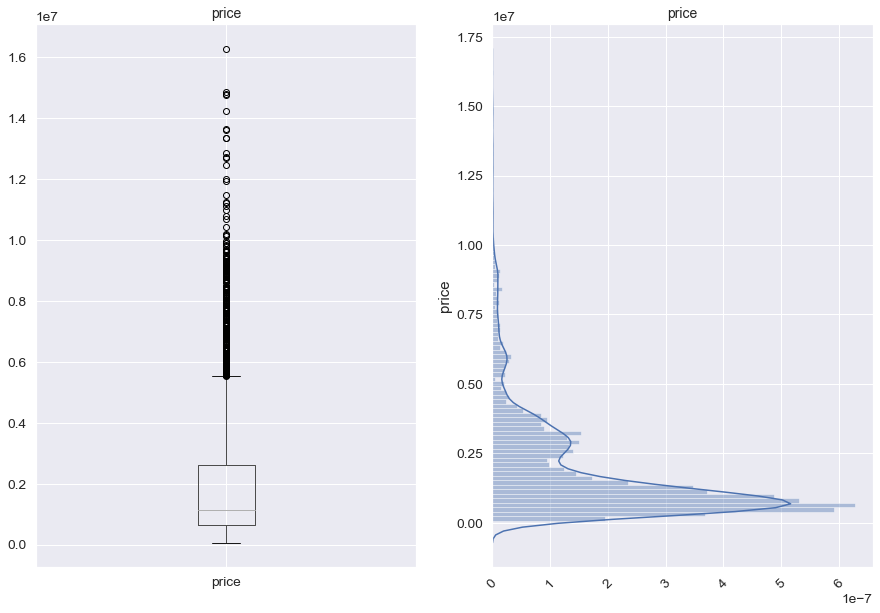

==== price ====
        count          mean           std      min       25%        50%  \
price  6985.0  1.854757e+06  1.843000e+06  60000.0  650000.0  1150000.0   

             75%         max  
price  2603800.0  16290000.0   

There are 0 missing values in 'price'. 




In [69]:
num_variable_analysis(data_bmw, target_name, target_name)

**Важно!** Порядок столбцов в `test` и `data_bmw` (после исключением целевого признака) должен совпадать!

In [70]:
test = test[ (data_bmw.drop([target_name], axis=1)).columns ]

In [71]:
# data_bmw.to_csv(FILEPATH + "cars_train_bmw.csv")

# 9 Реализация предсказателя для конкретной задачи - предсказание цен на BMW (Estimator realization for BMW price prediction)

Поскольку предоставленные для предсказания данные имеют меньшее число признаков (как и, в общем-то, меньшее число имеющихся признаков) стоит обучить нашу модель на данных, соответствующих задаче - предсказать цены на автомобили BMW.

## 9.1 Создание обучающей и прочих выборок

In [72]:
# data_train_bmw, data_test_bmw = train_test_split(data_bmw, test_size=0.2, random_state=RANDOM_STATE)
# data_train_bmw, data_valid_bmw = train_test_split(data_train_bmw, test_size=0.25, random_state=RANDOM_STATE)

data_train_bmw, data_valid_bmw = train_test_split(data_bmw, test_size=0.25, random_state=RANDOM_STATE)

print("We have {} entities total.".format( len(data_bmw) ))
print("We took {} entities for train dataset".format( len(data_train_bmw)))
print("        {} entities for valid dataset".format( len(data_valid_bmw)))
# print("        {} entities for test dataset".format( len(data_test_bmw)))


print("The target values in train are in range         [{}, {}] "
      .format( data_train_bmw[target_name].min(), data_train_bmw[target_name].max() ))
print("The target values in valid are in range         [{}, {}] "
      .format( data_valid_bmw[target_name].min(), data_valid_bmw[target_name].max() ))
# print("The target values in test are in range          [{}, {}] "
#       .format( data_test_bmw[target_name].min(), data_test_bmw[target_name].max() ))
print("The target values in whole dataset are in range [{}, {}] "
      .format( data_bmw[target_name].min(), data_bmw[target_name].max() ))

We have 6985 entities total.
We took 5238 entities for train dataset
        1747 entities for valid dataset
The target values in train are in range         [60000, 16290000] 
The target values in valid are in range         [75000, 14855700] 
The target values in whole dataset are in range [60000, 16290000] 


## 9.2 Оптимизация 'BMW'-предсказателя

In [73]:
EstimatorClass = 'lgbm'



### fixed parameters

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 168
param_dict_fix['learning_rate'] = 0.084
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 13
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit



### variable parameters

params_lim = {}

### MARK: RANGE ADJUST
params_lim['n_estimators'] = [159, 179, 'int']
params_lim['learning_rate'] = [0.08, 0.10, 'float']
params_lim['max_depth'] = [3, 23, 'int']

### FULL SEARCH
###
# params_lim['n_estimators'] = [2, 4002, 'int']
# params_lim['learning_rate'] = [0.001, 2.001, 'float']
# params_lim['max_depth'] = [2, 102, 'int']
# params_lim['num_leaves'] = [2, 127, 'int']
# params_lim['min_data_in_leaf'] = [2, 202, 'int']

[0]
params_limits : {'n_estimators': [159, 179, 'int'], 'learning_rate': [0.08, 0.1, 'float'], 'max_depth': [3, 23, 'int']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 11.760534 (tol=0.0001)
result_dict {'n_estimators': 169, 'learning_rate': 0.084, 'max_depth': 13}
Iteration time = 29.50 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [168, 170, 'int'], 'learning_rate': [0.083, 0.085, 'float'], 'max_depth': [12, 14, 'int']}
OUT [1]: M(i) = 11.760534; M(i+1) = 11.760534 (tol=0.0001)
result_dict {'n_estimators': 169, 'learning_rate': 0.084, 'max_depth': 13}
Iteration time = 15.37 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

11.760533800261182


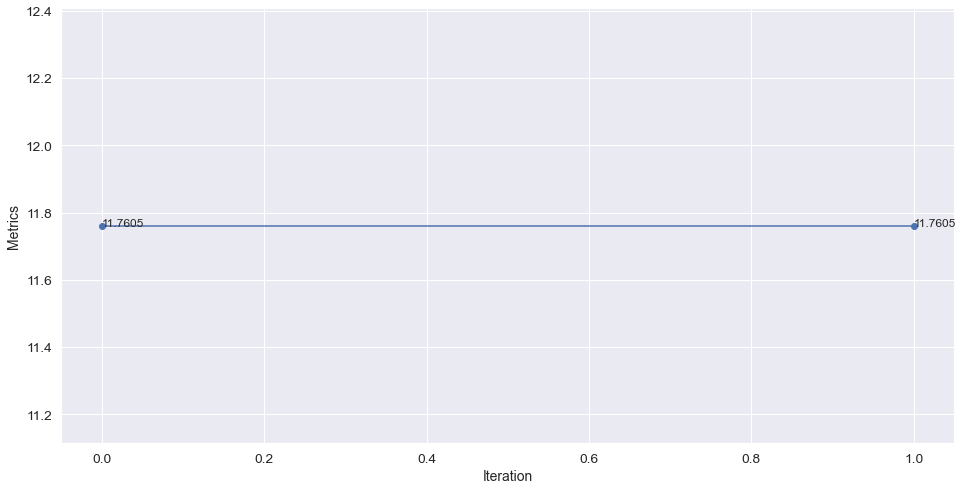


Done. Congratulations!
==== ==== ==== ==== ==== 
The parameters of the best base BMW-model are:  {'n_estimators': 169, 'learning_rate': 0.084, 'max_depth': 13}
The best base BMW-model has MAPE=11.7605
Wall time: 45.3 s


In [74]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_train_bmw, data_valid_bmw, target_name, N_SAMPLE_BASE, 
                            num_points=21,
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

print("==== "*5)
print("The parameters of the best base BMW-model are: ", result_dict)
print("The best base BMW-model has MAPE={:.4f}".format(metrics_out))

In [75]:
best_base_bmw_model_mape = metrics_out
best_base_bmw_parameters = result_dict
print("The best parameters for the base model are: ", best_base_bmw_parameters)
print("We have the MAPE = {:.4f} for the best base model. ".format(best_base_bmw_model_mape))

The best parameters for the base model are:  {'n_estimators': 169, 'learning_rate': 0.084, 'max_depth': 13}
We have the MAPE = 11.7605 for the best base model. 


## 9.3 Создание набора базовых моделей для мета-стадии

In [76]:
EstimatorClass = 'lgbm'



### fixed parameters

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 342
param_dict_fix['learning_rate'] = best_base_bmw_parameters['learning_rate']  ## 0.08
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 5


# param_dict_fix['max_depth'] = -1, ## no limit



### best optimised parameters

n_es_0 = best_base_bmw_parameters['n_estimators']
md_0 = best_base_bmw_parameters['max_depth']
# lr_0 = np.round(best_parameters['learning_rate'], 9)
# n_l_0 = best_parameters['num_leaves']
# mdil_0 = best_parameters['min_data_in_leaf']

params_optim = {}

params_optim['n_estimators'] = np.linspace( max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ),
                                           max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1), 
                                           num=N_grid, dtype='int' )
params_optim['max_depth'] = np.linspace( max( [2, md_0-STEP_INT*(N_grid-1)/2] ), 
                                        max( [2, md_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1),
                                        num = N_grid, dtype='int'  )

# params_optim['num_leaves'] = [max([2, n_l_0-STEP_INT]), n_l_0, n_l_0+STEP_INT ]
# params_optim['min_data_in_leaf'] = [max([2, mdil_0-STEP_INT]), mdil_0, mdil_0+STEP_INT ]
# params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]

# params_optim = {}
# params_optim['n_estimators'] = [1482, 1483, 1484] ##2264
# params_optim['max_depth'] = [10, 11, 12] ## 12
# params_optim['learning_rate'] = [0.067, 0.068, 0.069] ## 0.099

params_optim

{'n_estimators': array([168, 169, 170]), 'max_depth': array([12, 13, 14])}

In [77]:
%%time

base_bmw_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                          data_train_bmw, data_valid_bmw, target_name, N_SAMPLE_BASE, 
                          metrics_func=mean_absolute_percent_error,
                          lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)

['n_estimators', 'max_depth', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[168, 12, 11.823211503055878, 0.5900392532348633, <lightgbm.basic.Booster object at 0x000001CF85CFBD08>]
[168, 13, 11.76252657765951, 0.44658899307250977, <lightgbm.basic.Booster object at 0x000001CFFE115A88>]
[168, 14, 11.81556877870219, 0.4470345973968506, <lightgbm.basic.Booster object at 0x000001CF862E8E48>]
[169, 12, 11.822888279410629, 0.43408679962158203, <lightgbm.basic.Booster object at 0x000001CF865B3948>]
[169, 13, 11.760533800261182, 0.43157958984375, <lightgbm.basic.Booster object at 0x000001CF865B6448>]
[169, 14, 11.817678618688895, 0.40534472465515137, <lightgbm.basic.Booster object at 0x000001CFFE121508>]
[170, 12, 11.828471995652254, 0.42760443687438965, <lightgbm.basic.Booster object at 0x000001CF80AC3888>]
[170, 13, 11.761846418936535, 0.5030698776245117, <lightgbm.basic.Booster object at 0x000001CFFE3987C8>]
[170, 14, 11.809120643209807, 0.644324541091919, <lightgbm.basic.Booster object at 0x000001CF815F9AC8>]
Wall time: 4.43 s


In [78]:
base_bmw_model_storage = base_bmw_model_storage[ -base_bmw_model_storage['metrics'].duplicated() ]
base_bmw_model_storage.reset_index(inplace=True)
base_bmw_model_storage = base_bmw_model_storage.drop(['index'], axis=1)
# base_bmw_model_storage

## 9.4 About the best 'BMW' base model. Feature importance.

In [79]:
best_base_bmw_model = base_bmw_model_storage.loc[0, "model"]
print("Best base 'BMW' model demonstrates MAPE = {:.4f} with valid sample."
      .format(base_bmw_model_storage.loc[0, "metrics"]))

Best base 'BMW' model demonstrates MAPE = 11.7605 with valid sample.


In [80]:
feat_importances_best_base_bmw_model = pd.DataFrame(
    data=100*best_base_bmw_model.feature_importance()/best_base_bmw_model.feature_importance().sum(), 
    index=data_train_bmw.drop([target_name], axis=1).columns, columns=['Importance_(%)'])

feat_importances_best_base_bmw_model = feat_importances_best_base_bmw_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False)
feat_importances_best_base_bmw_model.head(20)

,Importance_(%)
mileage,22.947908
year,19.159432
power,12.430939
displacement,7.537490
model,4.893449
color,3.433307
doors_count,3.216259
owners,2.071823
engine_type,1.874507
body_type,1.578532


In [81]:
print("Feature with zero importance:")
feat_importances_best_base_bmw_model[ feat_importances_best_base_bmw_model['Importance_(%)'] == 0 ]

Feature with zero importance:


,Importance_(%)


In [82]:
feat_importances_best_base_bmw_model.tail(10)

,Importance_(%)
esp,0.355170
lane-keeping-assist,0.335438
airbag-passenger,0.315706
activ-suspension,0.276243
multizone-climate-control,0.256511
condition,0.236780
drowsy-driver-alert-system,0.217048
laser-lights,0.118390
vsm,0.078927
collision-prevention-assist,0.059195


Удаление признаков с нулевой значимостью не меняет итоговое качество предсказания.

In [83]:
z = feat_importances_best_base_bmw_model[(feat_importances_best_base_bmw_model['Importance_(%)'] != 0) & 
                                         (feat_importances_best_base_bmw_model['Importance_(%)'].notna())].values.flatten()
y = np.log(z)
x = np.arange(0, len(y))

p = np.polyfit(x, y, 1)
length = float(-1/p[0])
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )

print("The 'exponential decay length' is {:.2f} 'features'.".format( length ))
print("A lack od features is about {:.1%}.".format(float(feature_deficiency)))

real_importance = np.exp( np.polyval(p, x) )

The 'exponential decay length' is 11.43 'features'.
A lack od features is about 1.8%.


In [84]:
feature_deficient = 0.01
print("We need {} instead of {} (nonzero), which we have now for feature sufficiency of {:.1%}, while now we have {:.1%}."
      .format( int(np.ceil( -length*np.log(feature_deficiency) )), len(x), 
              1-feature_deficient, 1-feature_deficiency ))

We need 46 instead of 46 (nonzero), which we have now for feature sufficiency of 99.0%, while now we have 98.2%.


In [85]:
ind_from = 6
ind_to = -1
x_app = x[ind_from:ind_to]
y_app = y[ind_from:ind_to]
p = np.polyfit(x_app, y_app, 1)
real_importance = np.exp( np.polyval(p, x_app) )

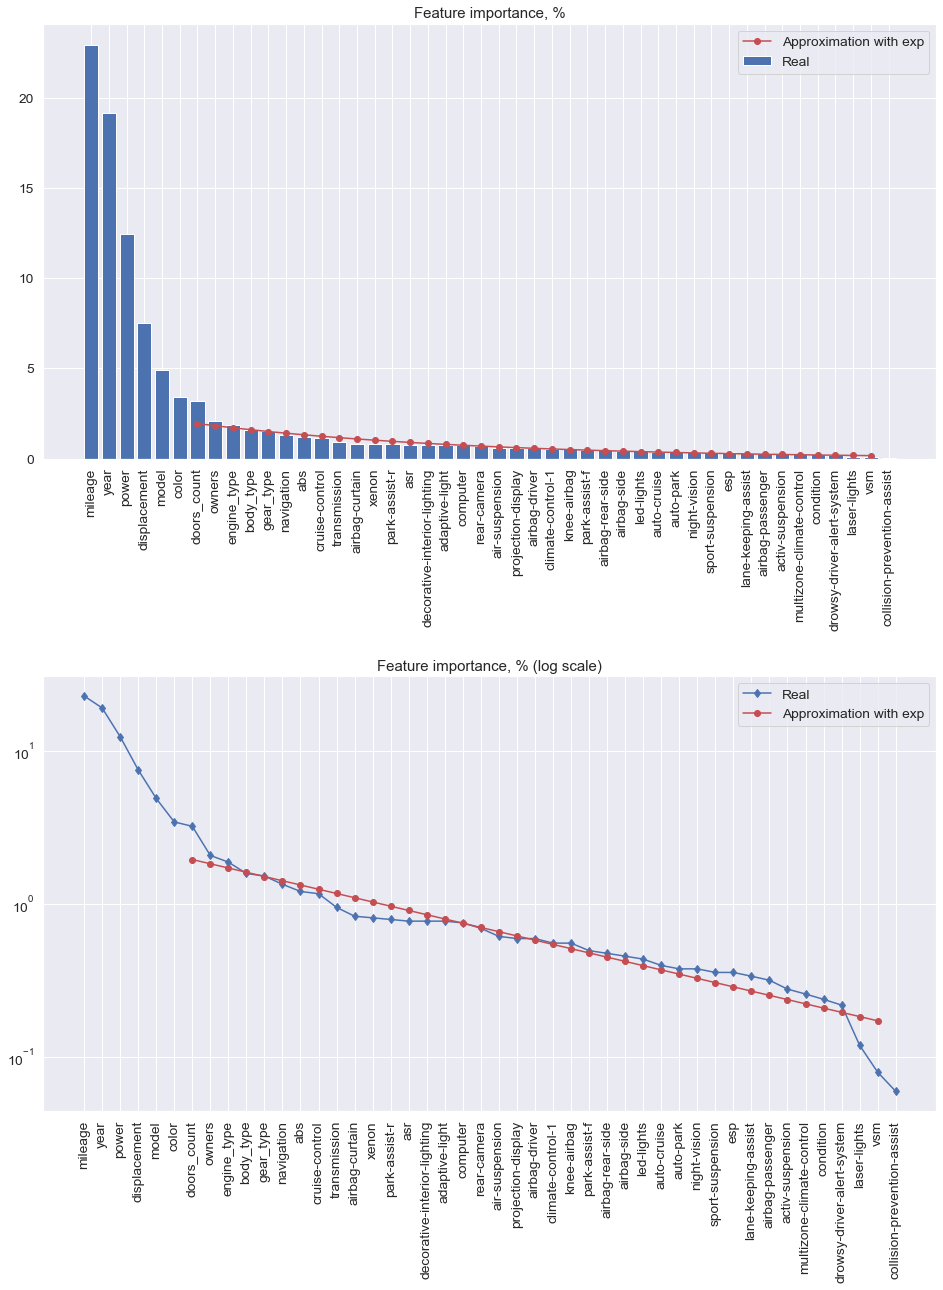

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(16, 20))
plt.subplots_adjust(hspace=0.5)

plt.subplot(2, 1, 1)
plt.bar(x, z, label="Real")
plt.plot(x_app, real_importance, '-ro', label='Approximation with exp')
plt.xticks(x, feat_importances_best_base_bmw_model.index, rotation=90)
plt.legend()
plt.title("Feature importance, %")


plt.subplot(2, 1, 2)
plt.semilogy(x, z, '-bd', label="Real")
plt.semilogy(x_app, real_importance, '-ro', label='Approximation with exp')
plt.xticks(x, feat_importances_best_base_bmw_model.index, rotation=90)
plt.legend()
plt.title("Feature importance, % (log scale)")

plt.show()

The range of prediction for Model No. 0 are: [120545.0, 13171840.0] with the width of 13051295.0
The range of prediction for Model No. 1 are: [120926.0, 13172481.0] with the width of 13051555.0
The range of prediction for Model No. 2 are: [120943.0, 13171814.0] with the width of 13050871.0


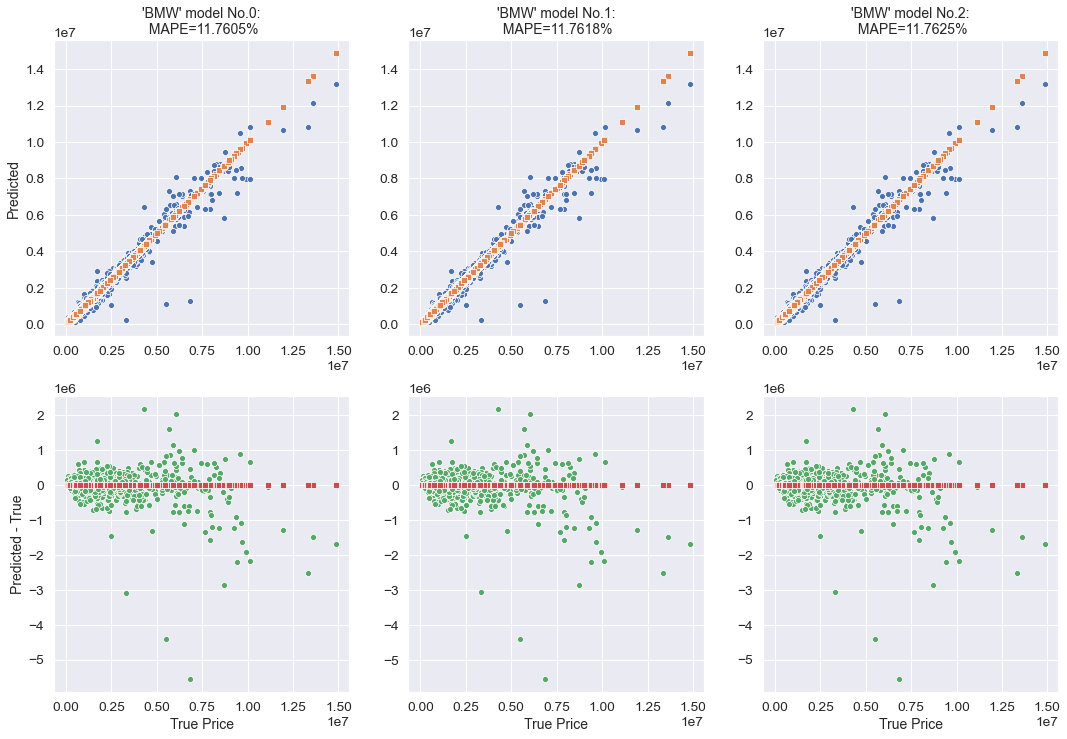

In [87]:
df = base_bmw_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_valid_bmw.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_valid_bmw.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_valid_bmw[target_name], prediction)
    sns.scatterplot(data_valid_bmw[target_name], data_valid_bmw[target_name], marker='s')
    plt.title("'BMW' model No.{}:\n MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_valid_bmw[target_name], prediction - data_valid_bmw[target_name], color='g')
    sns.scatterplot(data_valid_bmw[target_name], data_valid_bmw[target_name] - data_valid_bmw[target_name], 
                    marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)

plt.show()

## 9.6 Итоговое предсказание

Однако в случае с BMW стекинг не сработал. Быть может не хватило данных. 

Поэтому возьмём предсказание лучшей модели.

In [88]:
%%time

prediction_transformed = best_base_bmw_model.predict(test)
our_prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)

# print(prediction_transformed.min(), prediction_transformed.mean(), prediction_transformed.max())
print("Our predictions:")
print("Min =     " , our_prediction.min())
print("Mean =   ", int(our_prediction.mean()))
print("Median = ", int(np.median(our_prediction)))
print("Max =   ", int(our_prediction.max()))
our_prediction

Our predictions:
Min =      101562
Mean =    1610488
Median =  1194025
Max =    13023565
Wall time: 159 ms


array([1787176, 2712106, 1319795, ...,  516806, 1075302, 1045113])

In [89]:
our_prediction_df = pd.DataFrame([our_prediction]).T
our_prediction_df = our_prediction_df.reset_index(drop=True)
our_prediction_df.columns=[target_name]
our_prediction_df

,price
0,1787176
1,2712106
2,1319795
3,2501738
4,4856583
...,...
3832,1148852
3833,2704265
3834,516806
3835,1075302


In [90]:
our_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   3837 non-null   int64
dtypes: int64(1)
memory usage: 30.1 KB


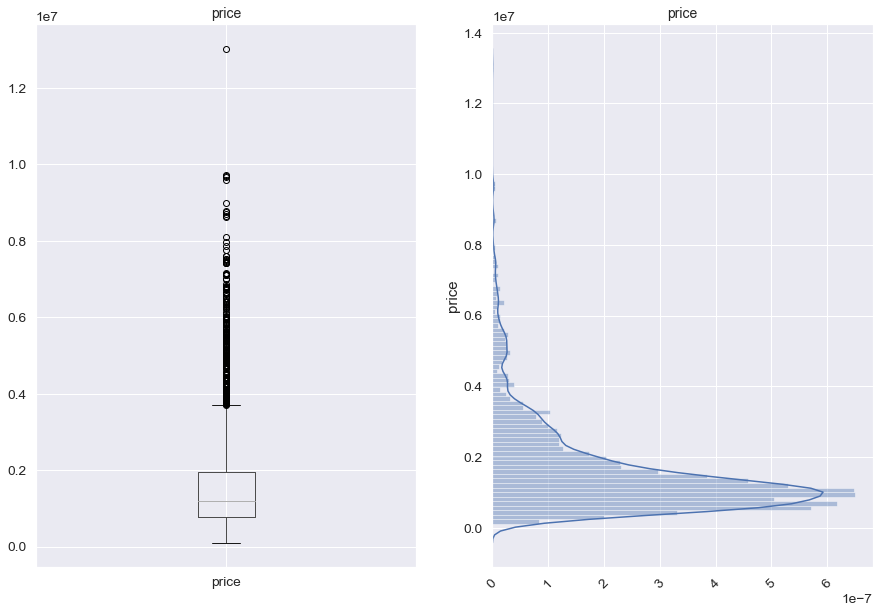

==== price ====
        count          mean           std       min       25%        50%  \
price  3837.0  1.610489e+06  1.318518e+06  101562.0  783181.0  1194025.0   

             75%         max  
price  1950884.0  13023565.0   

There are 0 missing values in 'price'. 




In [91]:
num_variable_analysis(our_prediction_df, target_name, target_name)

<div class="alert alert-block alert-info">
<div style="border:solid blue 2px; padding: 20px"> <h1 style="color:blue; margin-bottom:20px">
99 Results</h1>

</div>

In [92]:
def two_digit_presentation(x):
    if x < 10:
        return "0" + str(x)
    else:
        return str(x)
    

    
def two_digit_time_presentation(x):
    hours = x//3600
    minutes = ( x - 3600*hours) // 60
    seconds = x - 3600*hours - 60*minutes
    if hours > 0:
        ans = (two_digit_presentation(int(hours)) +  " h " 
               + two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    elif minutes > 0:
        ans = (two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    else:
        ans = (two_digit_presentation(round(seconds, 3)) + " sec")
    return ans

In [93]:
print("Best model demonstrates MAPE = {:.4f} with valid sample."
      .format(base_bmw_model_storage.loc[0, "metrics"]))

Best model demonstrates MAPE = 11.7605 with valid sample.


In [94]:
performance_time = time.time() - total_time_start

time_string_launch = date_start.strftime("%d %B %Y") + " at " + time_start.strftime("%H:%M")

date_finish = datetime.date.today()
time_finish = datetime.datetime.now().time()
time_string_finish = date_finish.strftime("%d %B %Y") + " at " + time_finish.strftime("%H:%M")


print( "The code was launched on              ", time_string_launch )
print( "The code finished its performance on  ", time_string_finish )
print()
print( "The full performance time is " + two_digit_time_presentation( performance_time ) )

The code was launched on               03 August 2020 at 22:55
The code finished its performance on   03 August 2020 at 22:58

The full performance time is 03 min 02 sec


In [95]:
yooo

NameError: name 'yooo' is not defined

In [ ]:
our_prediction_df

In [ ]:
our_prediction_df.to_csv(FILEPATH + "our_prediction.csv", index_label = 'id')

In [ ]:
check = pd.read_csv(FILEPATH + "our_prediction.csv")
check

## Appendix: Что ещё можно было бы сделать

1. Рефакторинг кода: есть остатки от предыдущих исследований с "висящими хвостами" (especially for the common case).
2. Сделать класс предсказателя:
  - принимает на вход параметры;
  - имеет метод `fit` (input: features_train, target_train);
  - имеет метод `predict` (input: features);
  - имеет метод `optimize` (желательно);
  - имеет метод `feature_importance` (желательно).
3. Написать толковые "доки" к полезным функциям